In [1]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/ModelsResults')

from mvesc_utility_functions import *
from estimate_prediction_model import *
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
with open('/mnt/data/mvesc/Models_Results/pkls/08_12_2016_grade_7_param_set_18_logit_ht_19297_logit.pkl', "rb" ) as f:
    d = pickle.load(f)
model_options = d['model_options']
d.keys()


dict_keys(['estimator', 'parameter_grid', 'train_set_soft_preds', 'val_y', 'test_y', 'cross_validation_scores', 'train_set_preds', 'features', 'train_y', 'model_options', 'val_set_preds', 'test_set_soft_preds', 'train_set_balance', 'model_name', 'val_set_soft_preds', 'file_name', 'time', 'test_set_preds'])

In [111]:
model = d['estimator']

In [115]:
model.intercept_

array([-1.5158848])

In [3]:
outcome_plus_features = build_outcomes_plus_features(model_options)
outcome_plus_features.dropna(subset=[model_options['outcome_name'],
        model_options['cohort_grade_level_begin']], inplace=True)

In [4]:
train = outcome_plus_features[outcome_plus_features.index.isin(d['train_y'].index)]
test = outcome_plus_features[outcome_plus_features.index.isin(d['test_y'].index)]
val = outcome_plus_features[outcome_plus_features.index.isin(d['val_y'].index)]

In [5]:
train_X = train.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
test_X = test.drop([model_options['outcome_name'],
                    model_options['cohort_grade_level_begin']],axis=1)
val_X = val.drop([model_options['outcome_name'],
                  model_options['cohort_grade_level_begin']],axis=1)
train_y = train[model_options['outcome_name']]
test_y = test[model_options['outcome_name']]
val_y = val[model_options['outcome_name']]

In [6]:
train_X, val_X, test_X = impute_missing_values(train_X, val_X, test_X,\
    model_options['missing_impute_strategy'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"

In [7]:
train_X, val_X, test_X = scale_features(train_X, val_X, test_X,
    model_options['feature_scaling'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"


In [35]:
binary_features = pd.DataFrame(~train_X.apply(lambda x: len(x.unique()),axis=0).gt(2), columns = ['binary'])
binary_features

,binary
ethnicity_A,True
ethnicity_B,True
ethnicity_H,True
ethnicity_I,True
ethnicity_M,True
ethnicity_nan,True
gender_F,True
disability_gr_6_autism,True
disability_gr_6_cognitive disability,True
disability_gr_6_deafness,True


In [102]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute("""select feature,importance from model.feature_scores
                                where filename = '08_12_2016_grade_7_param_set_18_logit_ht_19297'; """)
        temp = cursor.fetchall()
scores = pd.DataFrame(temp, columns = ['feature','importance'])

In [103]:
scores.set_index('feature', inplace=True)

In [104]:
scores.head()

,importance
feature,
status_gr_6_esc,7.729361
ethnicity_A,-5.125085
read_normalized_gr_4_isnull,-5.077234
disability_gr_6_multiple,-4.980336
math_normalized_gr_4_isnull,4.831779


In [105]:
scores = scores.join(binary_features)

In [106]:
scores.head()

,importance,binary
feature,,
status_gr_6_esc,7.729361,True
ethnicity_A,-5.125085,True
read_normalized_gr_4_isnull,-5.077234,True
disability_gr_6_multiple,-4.980336,True
math_normalized_gr_4_isnull,4.831779,True


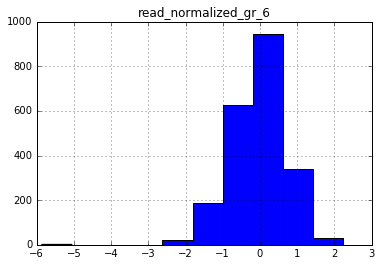

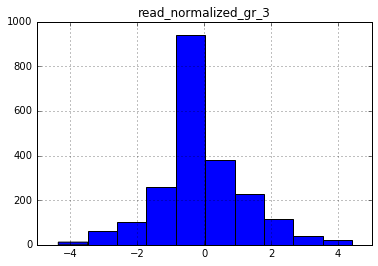

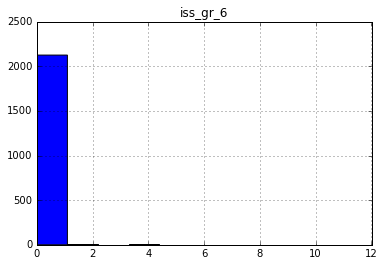

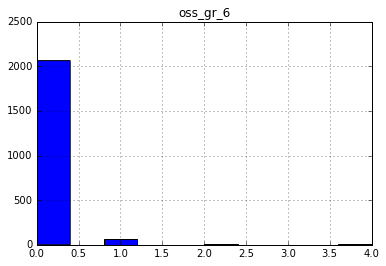

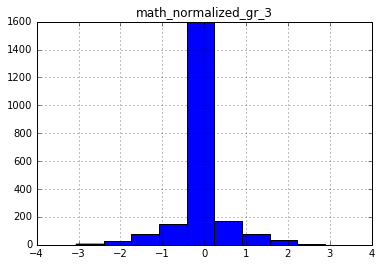

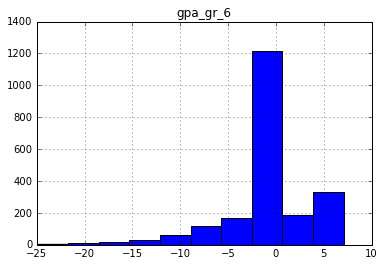

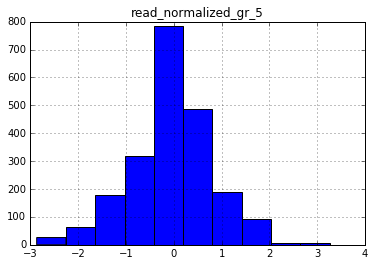

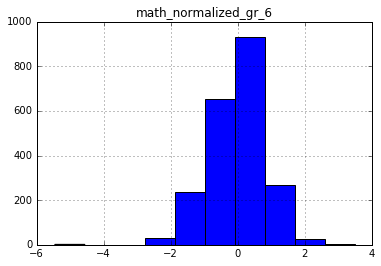

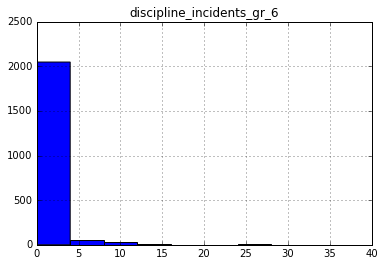

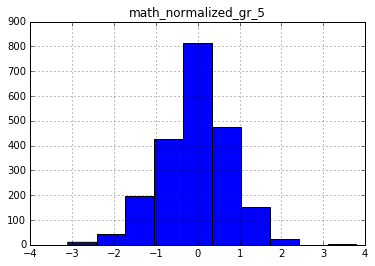

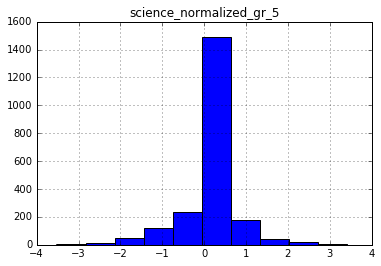

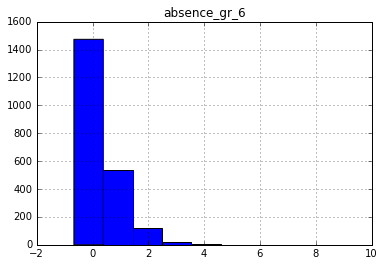

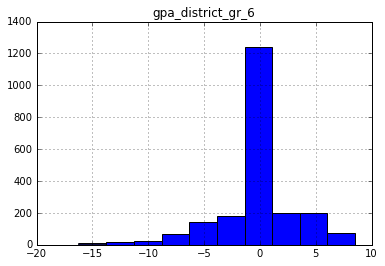

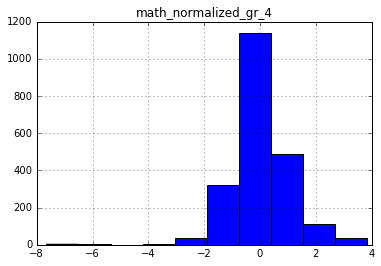

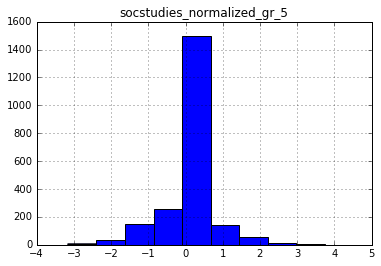

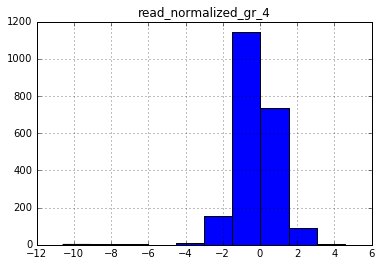

In [97]:
for c in train_X.columns[train_X.columns.isin(scores[~scores['binary']].index)]:
    plt.figure()
    train_X[c].hist()
    plt.title(c)

In [110]:
scores_weighted = scores
scores_weighted[~scores_weighted['binary']] = scores[~scores['binary']][['importance']]*5

SyntaxError: can't assign to function call (<ipython-input-110-3a16eb1e69da>, line 2)

In [99]:
scores_weighted.sort_values('importance')

,importance,binary
feature,,
ethnicity_A,-5.125085,1.0
read_normalized_gr_4_isnull,-5.077234,1.0
disability_gr_6_multiple,-4.980336,1.0
disability_gr_6_other major,-4.717634,1.0
ethnicity_I,-4.642865,1.0
disability_gr_6_deafness,-4.389572,1.0
status_gr_6_deleted,-4.311458,1.0
status_gr_6_excel,-3.618818,1.0
math_normalized_gr_6,-1.879860,NaN


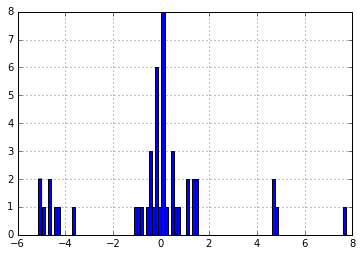

In [125]:
scores[scores['binary']]['importance'].hist(bins=100)

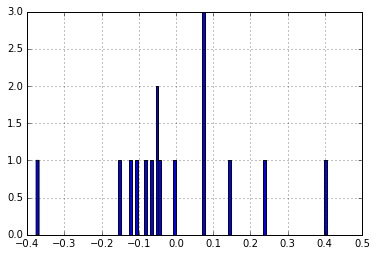

In [131]:
(scores[~scores['binary']]['importance']).hist(bins=100)

In [130]:
scores[~scores['binary']].sort_values('importance')

,importance,binary
feature,,
math_normalized_gr_6,-0.375972,False
math_normalized_gr_5,-0.151170,False
read_normalized_gr_5,-0.124593,False
science_normalized_gr_5,-0.106116,False
socstudies_normalized_gr_5,-0.085661,False
read_normalized_gr_4,-0.069382,False
read_normalized_gr_3,-0.054917,False
gpa_district_gr_6,-0.051910,False
gpa_gr_6,-0.041654,False


In [134]:
scores['importance']

feature
status_gr_6_esc                                   7.729361
ethnicity_A                                      -5.125085
read_normalized_gr_4_isnull                      -5.077234
disability_gr_6_multiple                         -4.980336
math_normalized_gr_4_isnull                       4.831779
special_ed_gr_6_50                                4.760360
disability_gr_6_traumatic brain injury            4.742509
disability_gr_6_other major                      -4.717634
ethnicity_I                                      -4.642865
disability_gr_6_deafness                         -4.389572
status_gr_6_deleted                              -4.311458
status_gr_6_excel                                -3.618818
status_gr_6_foster                                1.523481
disability_gr_6_autism                            1.465445
ethnicity_H                                       1.332448
math_normalized_gr_5_isnull                       1.325211
math_normalized_gr_6_isnull                     

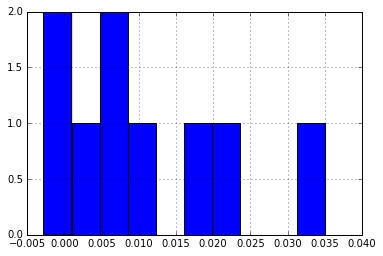

In [151]:
(train_X[train_X.columns[~scores['binary']]]*scores['importance'][~scores['binary']]).mean(axis=0).hist()


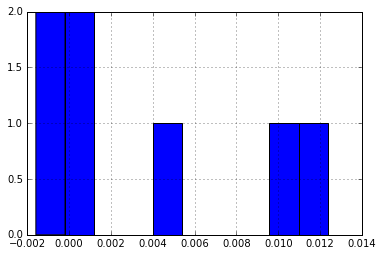

In [153]:
(train_X[train_X.columns[scores['binary']]]*scores['importance'][~scores['binary']]).mean(axis=0).hist()


In [161]:
pd.DataFrame((train_X*scores['importance']).mean(axis=0), columns=['importance']).sort_values('importance')

,importance
read_normalized_gr_4_isnull,-1.076345
special_ed_gr_6_100,-0.438882
read_normalized_gr_5_isnull,-0.143150
math_normalized_gr_3_isnull,-0.088916
read_normalized_gr_6_isnull,-0.068117
district_gr_6_Riverview,-0.054124
district_gr_6_West Muskingum,-0.047577
district_gr_6_TriValley,-0.037219
district_gr_6_Franklin,-0.034518
district_gr_6_Maysville,-0.029941
